## 🐼 Data Analysis

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

### Loading Data

In [304]:
PATH = 'synthetic_ride_hail_phnom_penh.csv'

data = pd.read_csv(PATH)
data.head()

,trip_id,date,dept_lat,dept_lon,arr_lat,arr_lon,vehicle_type,request_time,wait_time_min,trip_distance_km,est_time_min,actual_time_min,arr_time,fare_usd,surge_pricing,tip_usd,driver_rating,traffic_level,weather,estimated_CO2_g
0,1,2026-02-01,11.533592,104.875945,11.532852,104.872658,Rickshaw,06:39,7,5.09,17,30,07:09,2.33,1.0,1.32,5,Very High,Cloudy,392.27
1,2,2026-02-01,11.570388,104.868549,11.609510,104.965489,Remork,08:58,6,5.85,20,23,09:21,3.07,1.0,1.26,5,High,Clear,468.73
2,3,2026-02-01,11.530743,104.958590,11.602589,104.902785,Rickshaw,20:33,3,5.33,18,21,20:54,2.59,1.0,0.00,5,Medium,Clear,339.90
3,4,2026-02-01,11.553934,104.861142,11.540238,104.946489,Remork,08:40,9,2.45,8,11,08:51,1.74,1.3,0.58,5,Very High,Clear,204.04
4,5,2026-02-01,11.570571,104.888023,11.546010,104.924600,Remork,14:32,6,4.26,14,16,14:48,2.40,1.0,1.30,5,High,Cloudy,474.37


In [305]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   trip_id           2168 non-null   int64  
 1   date              2168 non-null   object 
 2   dept_lat          2168 non-null   float64
 3   dept_lon          2168 non-null   float64
 4   arr_lat           2168 non-null   float64
 5   arr_lon           2168 non-null   float64
 6   vehicle_type      2168 non-null   object 
 7   request_time      2168 non-null   object 
 8   wait_time_min     2168 non-null   int64  
 9   trip_distance_km  2168 non-null   float64
 10  est_time_min      2168 non-null   int64  
 11  actual_time_min   2168 non-null   int64  
 12  arr_time          2168 non-null   object 
 13  fare_usd          2168 non-null   float64
 14  surge_pricing     2168 non-null   float64
 15  tip_usd           2168 non-null   float64
 16  driver_rating     2168 non-null   int64  


### Statistical Summary

In [306]:
coordinates = ['dept_lat', 'dept_lon', 'arr_lat', 'arr_lon']
all_quan_cols = data.select_dtypes(include='number').columns.tolist()
quan_cols = [col for col in all_quan_cols if col not in coordinates]
qual_cols = data.select_dtypes(exclude='number').columns.tolist()

print("Coordinate Columns:", coordinates)
print("Quantitative Columns:", quan_cols)
print("Qualitative Columns:", qual_cols)

Coordinate Columns: ['dept_lat', 'dept_lon', 'arr_lat', 'arr_lon']
Quantitative Columns: ['trip_id', 'wait_time_min', 'trip_distance_km', 'est_time_min', 'actual_time_min', 'fare_usd', 'surge_pricing', 'tip_usd', 'driver_rating', 'estimated_CO2_g']
Qualitative Columns: ['date', 'vehicle_type', 'request_time', 'arr_time', 'traffic_level', 'weather']


In [307]:
# Drop Trip ID and date
quan_cols.remove('trip_id')
print("trip_id has been removed from quan_cols")

qual_cols.remove('date')
print("date has been removed from qual_cols")

trip_id has been removed from quan_cols
date has been removed from qual_cols


In [308]:
# Classify request_time to time of day
from datetime import datetime

# calculate the hours into minutes
data_time_minutes = pd.to_datetime(data['request_time']).dt.hour * 60 + pd.to_datetime(data['request_time']).dt.minute

bins= [360, 540, 720, 900, 1080, 1260, 1440]
time_category = ['Morning', 'Late Morning', 'Afternoon', 'Late Afternoon', 'Evening', 'Night']
data_time = pd.cut(data_time_minutes, bins=bins, labels=time_category)

C:\Users\eungl\AppData\Local\Temp\ipykernel_27660\240546959.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_time_minutes = pd.to_datetime(data['request_time']).dt.hour * 60 + pd.to_datetime(data['request_time']).dt.minute
C:\Users\eungl\AppData\Local\Temp\ipykernel_27660\240546959.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_time_minutes = pd.to_datetime(data['request_time']).dt.hour * 60 + pd.to_datetime(data['request_time']).dt.minute


In [309]:
data_time.name = 'time_of_day'

| Label | Minutes | Time |
|-------|---------|------|
| Morning | 360 - 539 | 06:00 - 08:59 |
| Late Morning | 540 - 719 | 09:00 - 11:59 |
| Afternoon | 720 - 899 | 12:00 - 14:59 |
| Late Afternoon | 900 - 1079 | 15:00 - 17:59 |
| Evening | 1080 - 1259 | 18:00 - 20:59 |
| Night | 1260 - 1440 | 21:00 - 23:59 |

In [310]:
data = pd.concat([data, data_time], axis=1)

In [311]:
# initially, date is in string object, so gotta convert into datetime [D -> date specific] format, in order to apply np.is_busday 
is_weekday = np.is_busday(pd.to_datetime(data['date']).values.astype('datetime64[D]')).astype(int)
is_weekend = (~np.is_busday(pd.to_datetime(data['date']).values.astype('datetime64[D]'))).astype(int)

In [312]:
data['day'] = pd.to_datetime(data['date']).dt.day_name()

data['is_weekday'] = is_weekday
data['is_weekend'] = is_weekend

In [313]:
data.sample(5)

,trip_id,date,dept_lat,dept_lon,arr_lat,arr_lon,vehicle_type,request_time,wait_time_min,trip_distance_km,...,surge_pricing,tip_usd,driver_rating,traffic_level,weather,estimated_CO2_g,time_of_day,day,is_weekday,is_weekend
278,279,2026-02-04,11.589714,104.961669,11.594623,104.898246,EV Car,18:00,3,5.56,...,1.2,1.70,4,Medium,Smog,27.78,Late Afternoon,Wednesday,1,0
1637,1638,2026-02-22,11.516544,104.941949,11.568219,104.960609,Rickshaw,17:04,3,3.70,...,1.2,0.00,5,Medium,Clear,201.29,Late Afternoon,Sunday,0,1
899,900,2026-02-12,11.520472,104.935960,11.599228,104.944190,Motor Dup,09:09,5,6.70,...,1.0,0.00,5,High,Clear,514.12,Late Morning,Thursday,1,0
2071,2072,2026-02-27,11.591348,104.936999,11.598125,104.887093,Rickshaw,06:03,6,8.05,...,1.0,0.00,5,High,Smog,519.21,Morning,Friday,1,0
763,764,2026-02-11,11.585389,104.885986,11.606930,104.870410,Remork,10:05,2,5.08,...,1.0,4.57,5,Low,Clear,512.25,Late Morning,Wednesday,1,0


### 1. Descriptive

In [314]:
print("Quantitative Data Statistical Summary")
data[quan_cols].describe()

Quantitative Data Statistical Summary


,wait_time_min,trip_distance_km,est_time_min,actual_time_min,fare_usd,surge_pricing,tip_usd,driver_rating,estimated_CO2_g
count,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.00000
mean,4.613007,6.011070,20.040129,23.541052,3.617744,1.190406,0.864234,4.383764,376.47720
std,2.187382,1.966546,6.559708,7.742342,1.686932,0.180217,1.704709,0.865881,229.94605
min,1.000000,0.500000,2.000000,1.000000,0.200000,1.000000,0.000000,1.000000,0.11000
25%,3.000000,4.707500,16.000000,18.000000,2.420000,1.000000,0.000000,4.000000,229.07750
50%,5.000000,5.970000,20.000000,23.000000,3.370000,1.200000,0.000000,5.000000,383.31000
75%,6.000000,7.342500,24.000000,29.000000,4.540000,1.300000,1.240000,5.000000,523.98250
max,13.000000,12.630000,42.000000,51.000000,13.150000,1.500000,9.980000,5.000000,1252.84000


In [ ]:
qual_cols.remove('request_time')
qual_cols.remove('arr_time')
qual_cols.append('day')
qual_cols.append('time_of_day')

In [319]:
print("Qualitative Data Stastical Summary")

for var in qual_cols:
    # print(data[var].unique())
    print(f"Statistical Summary of {var}:\n")
    print(data[var].value_counts())

Qualitative Data Stastical Summary
Statistical Summary of vehicle_type:

vehicle_type
Rickshaw     1121
Remork        443
EV Car        376
Motor Dup     228
Name: count, dtype: int64
Statistical Summary of traffic_level:

traffic_level
High         811
Medium       540
Very High    460
Low          357
Name: count, dtype: int64
Statistical Summary of weather:

weather
Clear     1092
Cloudy     639
Smog       221
Windy      216
Name: count, dtype: int64
Statistical Summary of day:

day
Sunday       324
Wednesday    322
Friday       308
Thursday     307
Saturday     304
Tuesday      303
Monday       300
Name: count, dtype: int64
Statistical Summary of time_of_day:

time_of_day
Morning           553
Afternoon         457
Evening           427
Late Afternoon    369
Late Morning      275
Night              85
Name: count, dtype: int64


In [320]:
len(quan_cols)

9

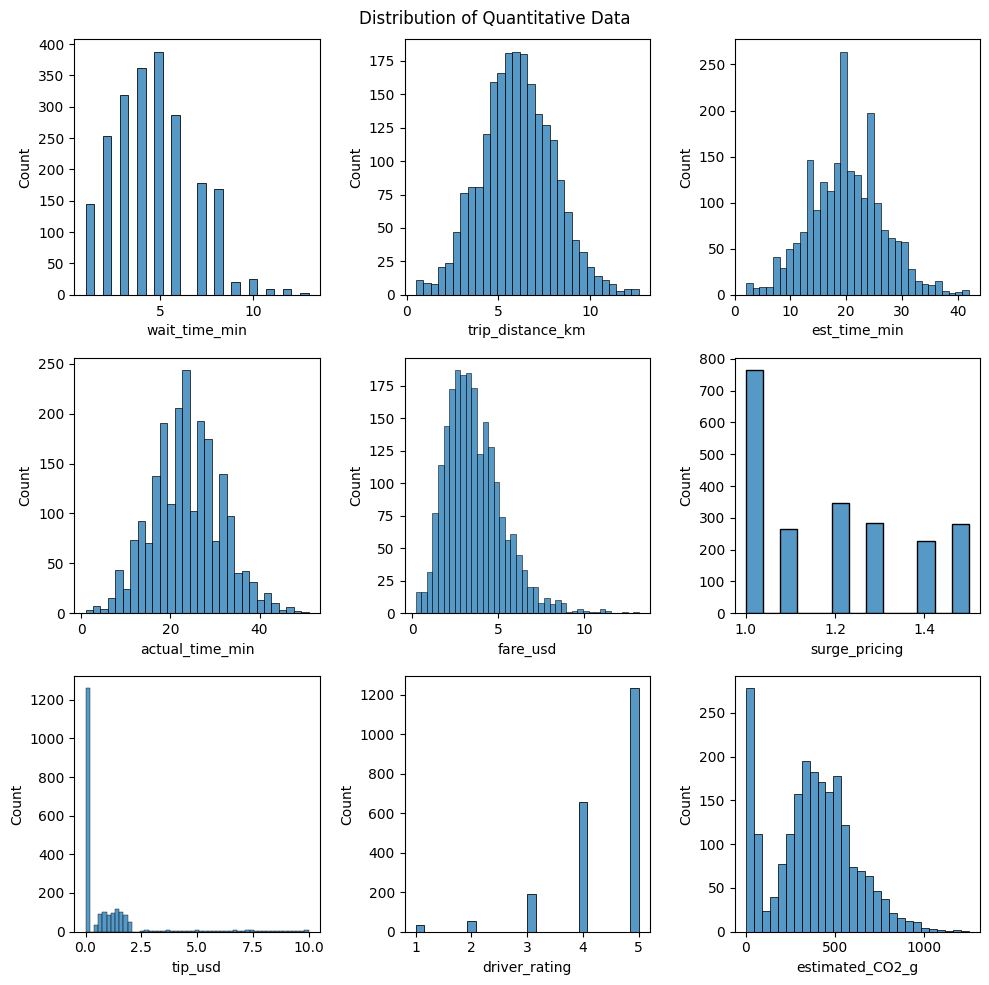

In [321]:
# Plot Quantitative Data
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i, var in enumerate(quan_cols):
    row = i // 3
    col = i % 3
    sns.histplot(data=data, x=var, ax=ax[row, col])

plt.suptitle("Distribution of Quantitative Data")
plt.tight_layout()

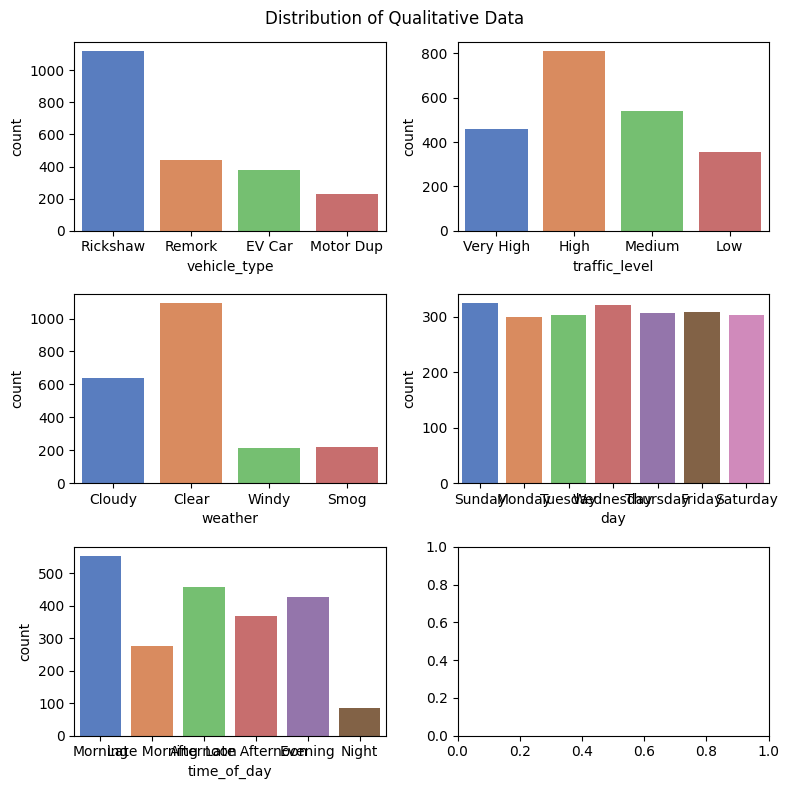

In [325]:
# Plot Qualtitative Data
fig, ax = plt.subplots(3, 2, figsize=(8, 8))

for i, var in enumerate(qual_cols):
    row = i // 2
    col = i % 2
    sns.countplot(data, x=var, ax=ax[row, col], hue=var, palette='muted', legend=False)

plt.suptitle("Distribution of Qualitative Data")
plt.tight_layout()

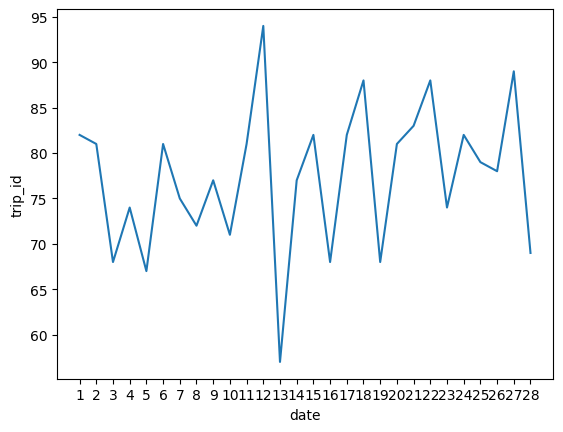

In [326]:
# Line Series of Request Time
# What time people request the most?

# First, we groupby trip_id by date
trip_by_date = data.groupby('date')['trip_id'].count()

# trip_by_date

ax = sns.lineplot(trip_by_date)

days = pd.to_datetime(trip_by_date.index).day # dtype='int32'; class = Index

ax.set_xticks(range(len(trip_by_date)))
ax.set_xticklabels(days)
# ax.title("Booking by Day")
plt.show()

### 2. Diagnostic


### Questions for Diagnostic Analysis (Correlation & Hypothesis)
1. Relationship between Estimated and Actual Time
2. Relationship between Weather Condition and Ride Time (must create a new column for finish time)

|Quan| vs |Quan|: Scatterplot 

|Quan| vs |Qual|: Boxplot, Stacked Bar Plot

|Qual| vs |Qual|: ANOVA

### Study for outliers

<Axes: xlabel='trip_distance_km'>

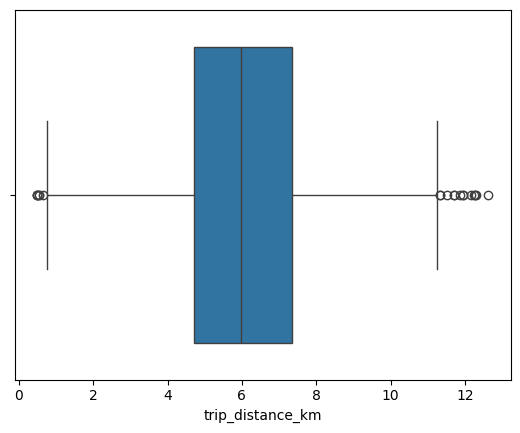

In [327]:
sns.boxplot(data, x='trip_distance_km')

#### Quan vs Quan

<Axes: xlabel='trip_distance_km', ylabel='tip_usd'>

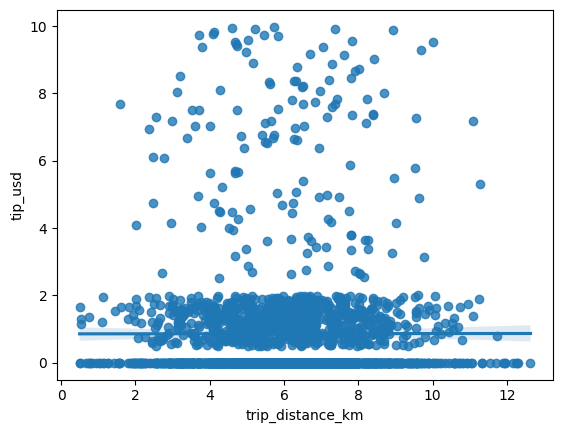

In [328]:
# Relationship between Distance and Tip
sns.regplot(data, x='trip_distance_km', y='tip_usd')

                 est_time_min  actual_time_min
est_time_min         1.000000         0.855914
actual_time_min      0.855914         1.000000


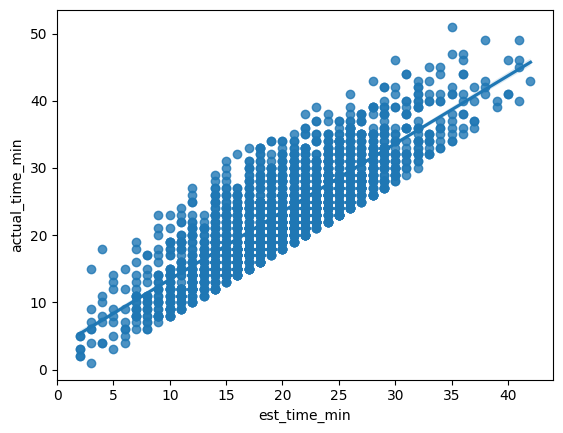

In [329]:
# Est and Actual Time
sns.regplot(data, x='est_time_min', y='actual_time_min')
print(data[['est_time_min', 'actual_time_min']].corr())

# dont forget to Change the weights for this in the dataset!

                  trip_distance_km  fare_usd
trip_distance_km          1.000000  0.721787
fare_usd                  0.721787  1.000000


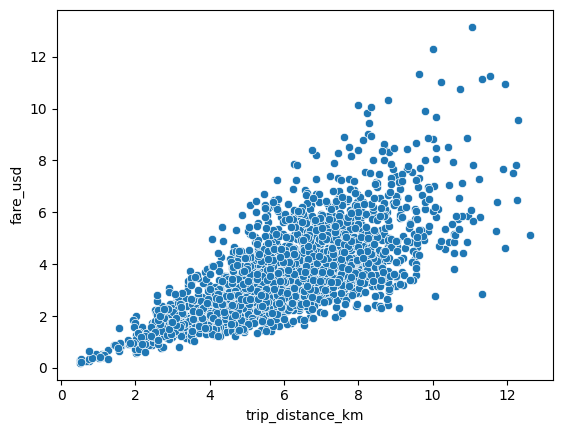

In [330]:
# Does trip distance affect actual time
sns.scatterplot(
    data,
    x='trip_distance_km',
    y='fare_usd'
)

print(data[['trip_distance_km', 'fare_usd']].corr())

Based on the graph,

#### Quan vs Qual

<Axes: xlabel='weather', ylabel='actual_time_min'>

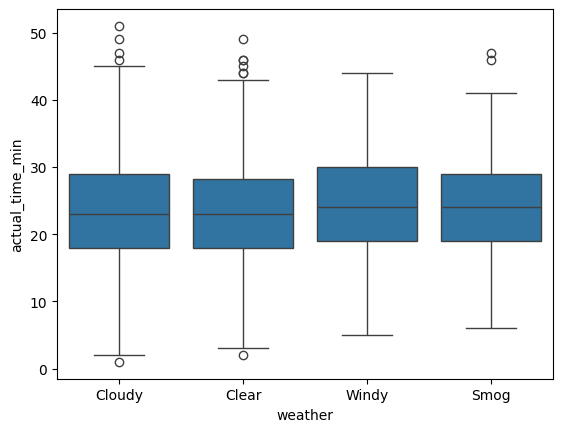

In [331]:
# Does weather condition affect actual ride time
sns.boxplot(data, x='weather', y='actual_time_min')

In [ ]:
# Does weekend and weekday have different ride proportion
# Does day of week affect the ride


<Axes: xlabel='surge_pricing', ylabel='fare_usd'>

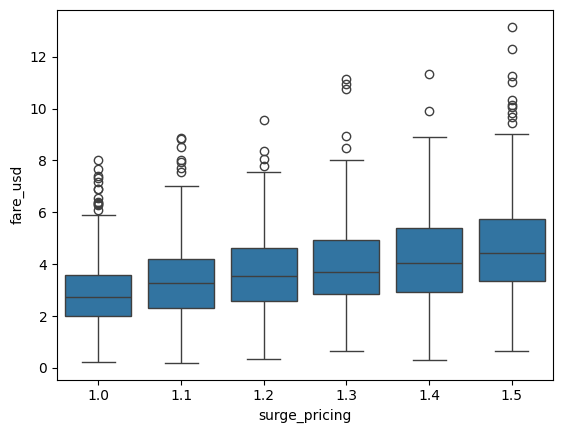

In [332]:
# Does surge pricing affect rating
sns.boxplot(data, x='surge_pricing', y='fare_usd')

In [ ]:
# Does time of day affect fare or trip distance?

In [333]:
# Qual vs Qual

# Is surge pricing more likely during certain weather conditions?
import pingouin as pg

aov = pg.anova(data=data, dv='surge_pricing', between='weather', effsize='n2')

aov

,Source,ddof1,ddof2,F,p-unc,n2
0,weather,3,2164,1.781081,0.148663,0.002463


### 3. Predictive

### 4. Prescriptive

### 5. Presentation Role
- Introduction & Problem Statement: Laimeng
- Descriptive:                      Sovann
- Study for outlier:                Sovann
- Diagnostic:                       Dona
- Prediction:                       Laimeng
- Prescriptive:                     Dona